# 因果推断与实验检验-DID分析   仅支持python3

## 引入DID工具包做因果分析检验 
原理参考 https://wiki.corp.kuaishou.com/display/public/Difference+in+Difference
1. [工具包介绍](https://wiki.corp.kuaishou.com/pages/viewpage.action?pageId=140065171)
2. [工具包使用流程](https://wiki.corp.kuaishou.com/pages/viewpage.action?pageId=135548045)
3. [工具包api手册](https://wiki.corp.kuaishou.com/pages/viewpage.action?pageId=134153875)
4. [直播功能分析案例](https://wiki.corp.kuaishou.com/pages/viewpage.action?pageId=140065252)

In [2]:
import sys 
sys.path.append('/home/public/benyuansong') 
from DID import did
from DID import ttest
from DID import preprocessing
import pandas as pd
from DID import filter

## DID分析 读取示例数据 
离线数据，亦可配合data_query线上获取数据

In [3]:
file = pd.read_csv('/home/public/ks_live_stream/live_chat_author_data_20190213_v1.csv')
outcome = ['live_stream_cnt','live_stream_duration','total_watching_duration','receive_amount','like_cnt','comment_cnt','share_cnt','pk_cnt','voice_comment_cnt']

In [4]:
file.tail(5)

,user_id,treatment,if_on,live_duration_7d,avg_acu_7d_range,receive_cnt_7d,receive_amount_7d,like_cnt_7d,total_enter_Live_cnt_7d,pk_cnt_7d,...,live_date,live_stream_duration,live_stream_cnt,total_watching_duration,receive_amount,like_cnt,comment_cnt,share_cnt,pk_cnt,voice_comment_cnt
3594010,1156728383,0,0,3339,1-5,14,14.0,60,50,0,...,2018-12-18,18719,2,67989,269.0,13450,251,5,0,0
3594011,1156728383,0,0,3339,1-5,14,14.0,60,50,0,...,2018-12-20,16746,1,13066,10.0,2054,39,0,0,0
3594012,1156728383,0,0,3339,1-5,14,14.0,60,50,0,...,2018-12-17,9495,1,16662,92.0,70,16,1,0,0
3594013,1156728383,0,0,3339,1-5,14,14.0,60,50,0,...,2018-12-15,8679,2,18419,3890.0,1217,35,2,0,0
3594014,1156728383,0,0,3339,1-5,14,14.0,60,50,0,...,2018-12-10,3339,1,6280,14.0,60,16,1,0,0


## DID分析 数据预处理
api详细说明： https://wiki.corp.kuaishou.com/pages/viewpage.action?pageId=134153875

 class preprocessing.did_preprocessing(data, treatment_col = 'treatment', name_col = 'user_id', date_col = 'date')

参数介绍：
data：输入的dataframe（仅支持pandas的dataframe格式的数据）
treatment_col: treatment的字段名，默认是'treatment'，根据自己的data情况填写
name_col: 分析个体的字段名，默认是'user_id',根据实际情况填写
date_col:分析时间字段的字段名，默认是'date'，根据实际情况填写
输出：
返回一个dataframe，经过了一些列预处理。

In [5]:
file = preprocessing.did_preprocessing(file, treatment_col = 'treatment', name_col = 'user_id', date_col = 'live_date')

## DID分析 matching处理
### 算法选择 psm匹配算法选择，耗时较长，可以跳过（DID分析）

In [6]:
did.algorithm_show(file, 3, -11, by_treatment=False, label='if_on')

/home/public/benyuansong/DID.py:130: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train,y_train)
/root/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/root/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/root/py37/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/root/py37/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector

,RandomForest,LogisticRegression,LightGBM,XGBoost
accuracy,0.639300,0.690859,0.668528,0.671189
auc_score,0.654740,0.637331,0.667557,0.666777
precision,0.271379,0.285970,0.289714,0.290582
recall,0.564391,0.448980,0.546158,0.540081
f1score,0.366522,0.349398,0.378598,0.377862
precision_0,0.869148,0.856457,0.871199,0.870450
recall_0,0.656291,0.745723,0.696284,0.700927
f1score_0,0.747869,0.797263,0.773982,0.776544


### DID分析 matching PSM匹配和CEM匹配
PSM：参数2和3为特征的索引分片（匹配特征的位置需要相邻），如果拟合的概率不是treatment，则by_treatment=False，label为拟合概率的变量，caliper为阈值，top表示输出特征重要性的数量

CEM：CEM匹配，参数2和3为特征的索引分片（匹配特征的位置需要相邻)；cutpoints为自定义连续性特征的分桶，支持字典，例如
{'fans_count':[10,100,500,1000,5000,10000,50000,100000,500000,1000000],'age':[18,25,30,35,40,50]}；
grouping为自定义离散型特征的分组，支持字典，
例如{'age_range':[['0-18'],['18-23','24-30'],['31-40'],['41-50','50+']],'fre_city_level':[['一线城市','新一线城市'],['二线城市','三线城市'],['四线城市','五线城市']]}
is_K2K参数指定匹配是否为1v1匹配；break_method指如果没有自定义连续型变量的分桶，使用的分桶算法为输出的文件添加了一个'weight'字段，后续分析要乘以这个权重。

In [7]:
matched,pscore,match_id,feature_importance=did.matching(file, 3, -11, model='LightGBM', by_treatment=False ,label='if_on', caliper=0.05,top=10)
feature_importance
#CEM匹配： matched = did.CEM(file, 3, -11, cutpoints = None, grouping = None, is_K2K=False, break_method = 'sturges')

/root/py37/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/root/py37/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,column,feature_importance
0,live_duration_7d,294
5,pk_cnt_7d,202
4,total_enter_Live_cnt_7d,195
1,receive_cnt_7d,193
3,like_cnt_7d,182
2,receive_amount_7d,141
6,voice_comment_cnt_7d,135
7,live_chat_num_7d,105
30,gender_F,103
12,is_install_jdqs_cjzc,92


### DID分析 Matching后 画出匹配后的概率分布
仅限PSM

/root/py37/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


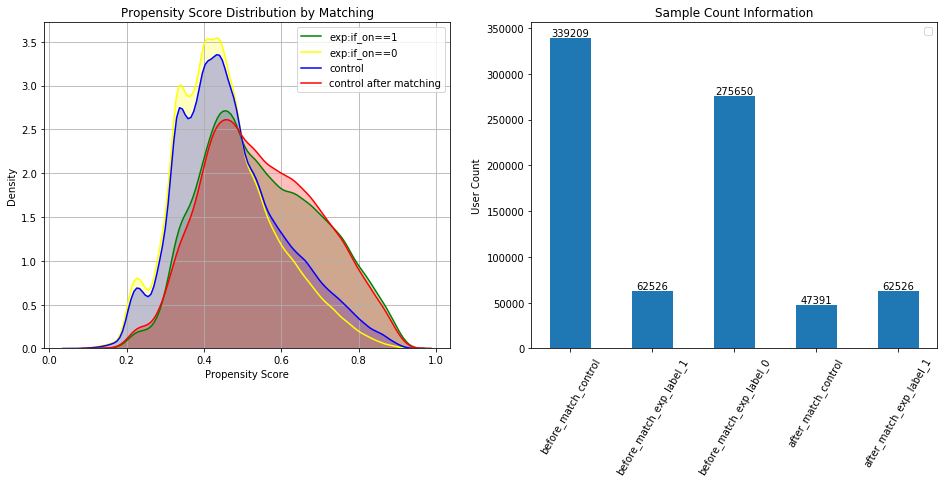

In [8]:
did.plotMatchedSample(file,pscore,match_id,by_treatment=False,label='if_on')

## DID分析 平行趋势检验
参数从左至右依次为分析数据dataframe，因变量字段名（支持列表），政策时间，横坐标步长

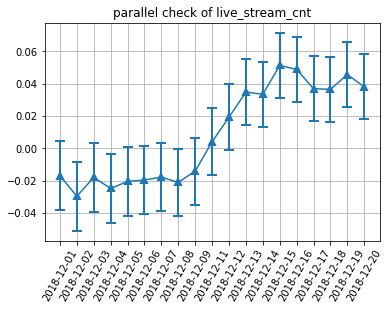

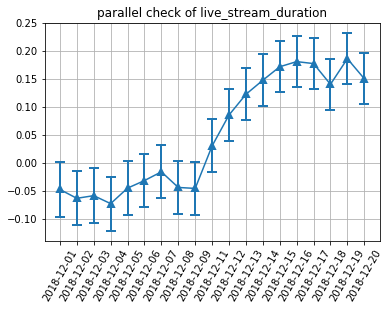

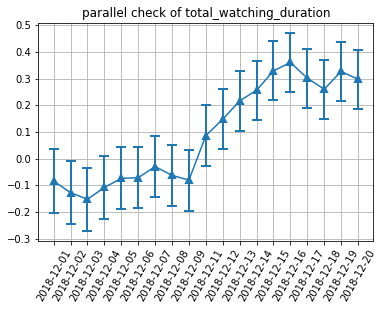

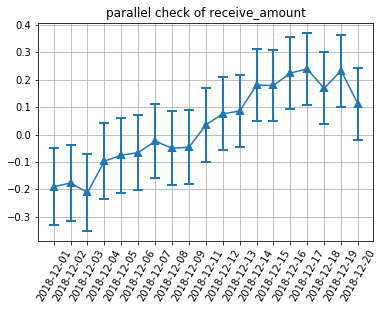

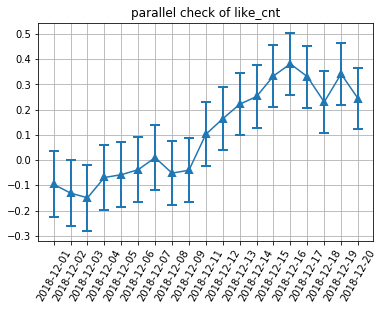

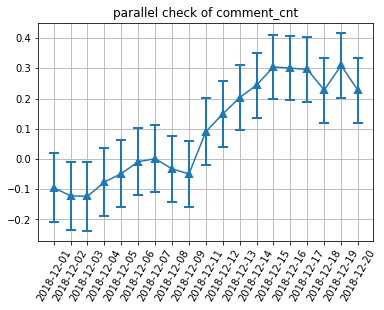

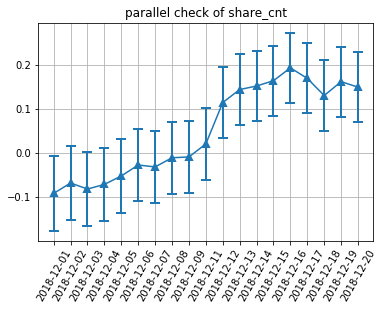

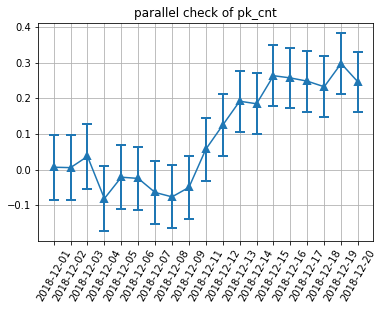

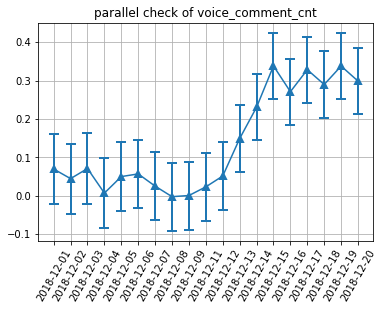

In [9]:
did.check_parallel(matched, outcome, '2018-12-11', step = 1)

## DID分析 匹配结果的平衡检验
平行趋势检验不过，需要进行这一步，查看哪个特征匹配的不好，bias要小于0.05

In [10]:
did.check_covariate_balance(matched,feature_importance['column'])

,treated,control,dif,bias
live_duration_7d,9772.295413,9949.401490,177.106077,0.008210
pk_cnt_7d,10.375108,10.565719,0.190611,0.004475
total_enter_Live_cnt_7d,2257.712104,2495.412884,237.700781,0.002784
receive_cnt_7d,135.654288,148.063577,12.409290,0.011315
like_cnt_7d,5211.514298,4902.575531,308.938767,0.001386
receive_amount_7d,9337.450389,11120.793632,1783.343243,0.012482
voice_comment_cnt_7d,22.147251,23.240193,1.092943,0.008274
live_chat_num_7d,1.332390,1.350320,0.017930,0.002846
gender_F,0.398234,0.403916,0.005682,0.011593
is_install_jdqs_cjzc,0.345312,0.352493,0.007181,0.015066


##  DID分析 输出结果

In [11]:
did.result(matched,outcome,'2018-12-11')

live_stream_cnt: did:0.1499819277936007 pvalue:8.559767504955416e-22 显著 提升百分比：5.56%
live_stream_duration: did:167.1513077064631 pvalue:8.797497213199291e-10 显著 提升百分比：4.44%
total_watching_duration: did:-12965.01949797866 pvalue:0.3288485987949369 不显著 提升百分比：-13.45%
receive_amount: did:-5.759415993808465 pvalue:0.8151246610049477 不显著 提升百分比：-1.00%
like_cnt: did:-146.56776333234737 pvalue:0.4523361678301766 不显著 提升百分比：-7.48%
comment_cnt: did:-7.806483515086351 pvalue:0.3209625484326072 不显著 提升百分比：-6.46%
share_cnt: did:-1.498570189526755 pvalue:0.29566844340824117 不显著 提升百分比：-29.78%
pk_cnt: did:0.48078278490958487 pvalue:2.9230771113342307e-10 显著 提升百分比：12.86%
voice_comment_cnt: did:0.37626823400816645 pvalue:0.12745551206691996 不显著 提升百分比：3.87%


## DID分析 结果可视化

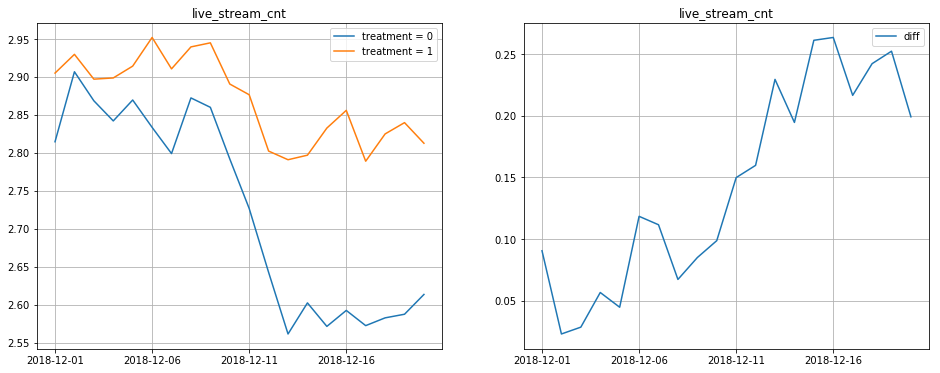

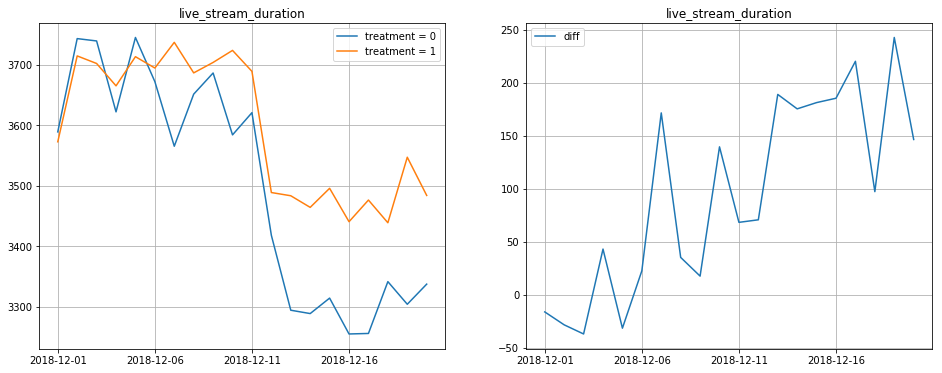

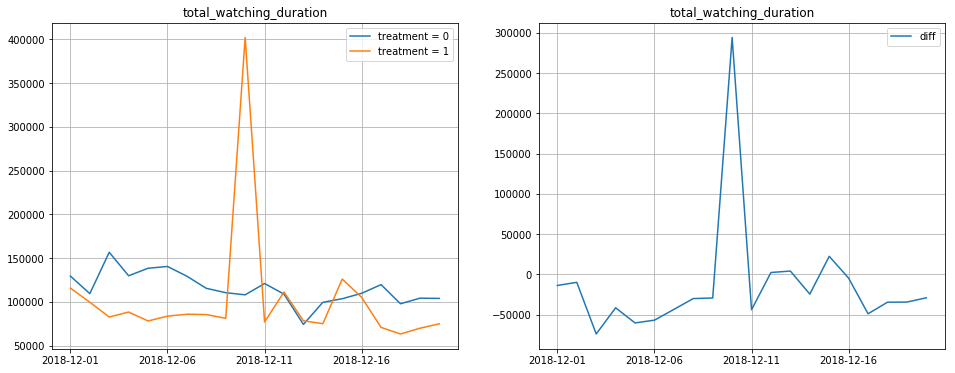

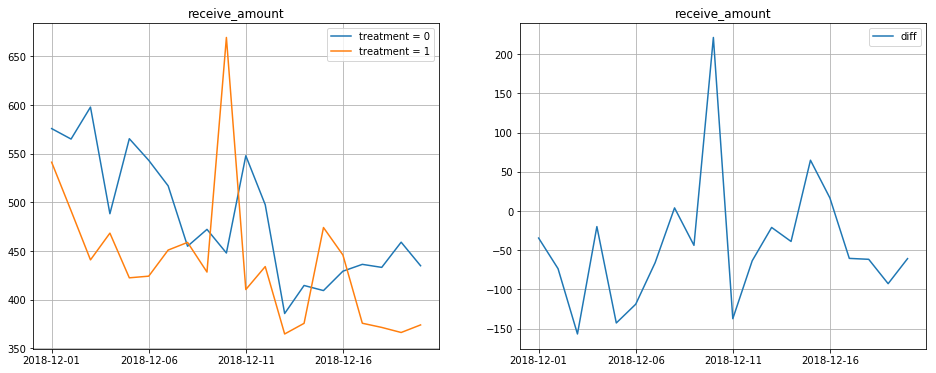

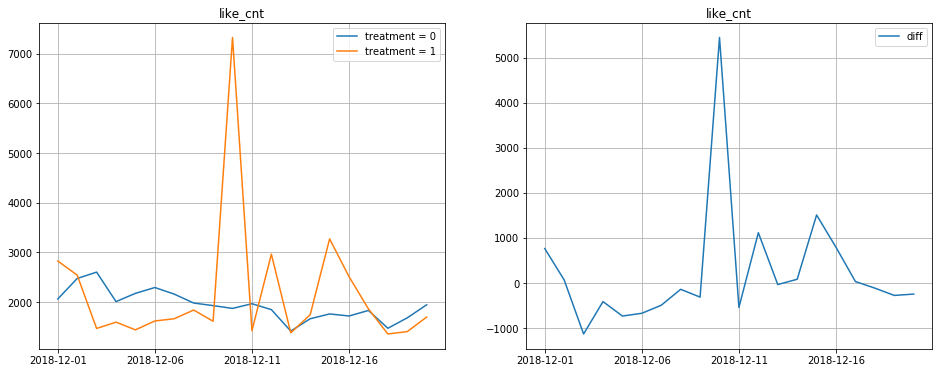

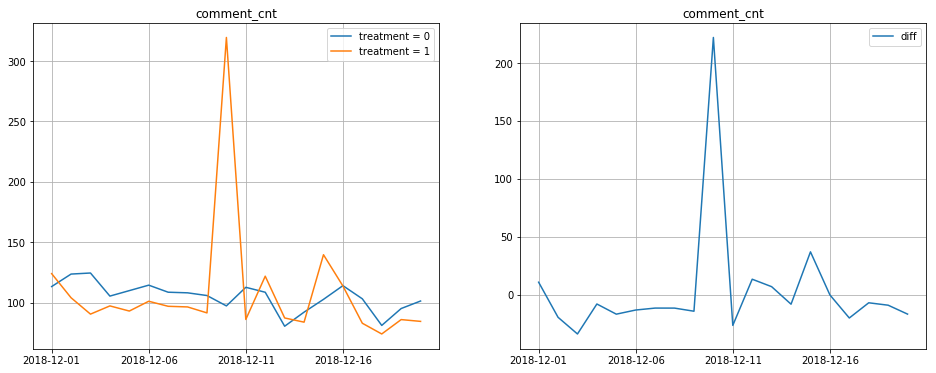

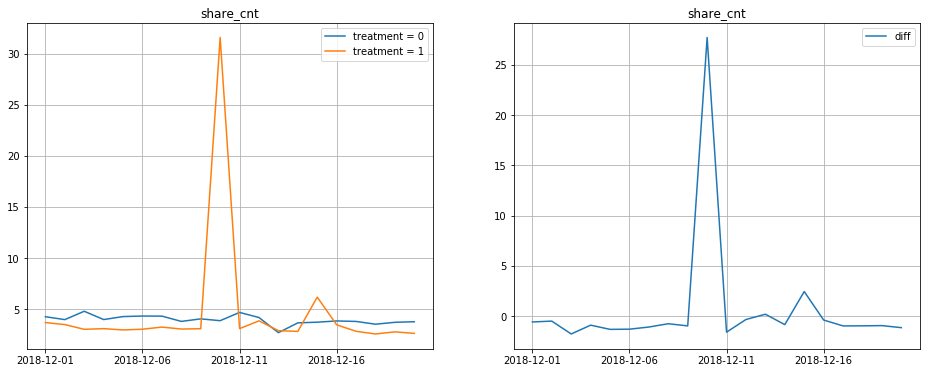

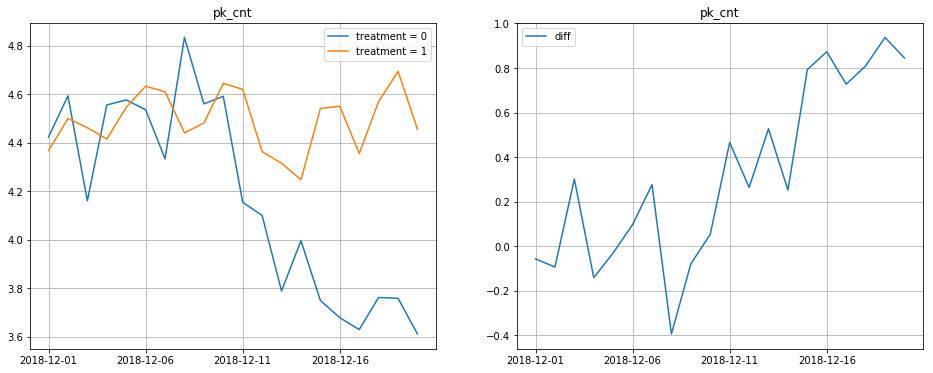

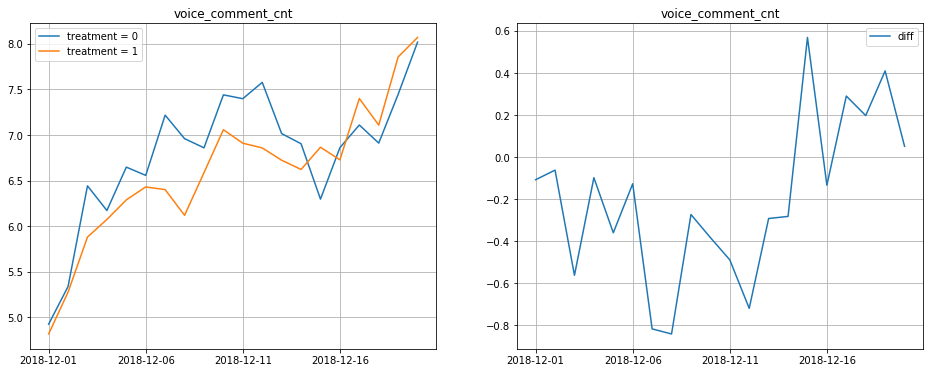

In [12]:
did.plotResult(matched[matched.gender=='M'], outcome, step = 5)

## DID分析可选操作
### filter处理，建一个filter类，进一步计算特定特征组合下的did结果（可选）

In [13]:
myfilter = filter('gender')
filter.filter_did(matched,myfilter,outcome,'2018-12-11')

When gender = M :
live_stream_cnt: did:0.14439019619937515 pvalue:1.0145507272378303e-11 显著 提升百分比：5.39%
live_stream_duration: did:124.41830194530476 pvalue:0.0003832769588794037 显著 提升百分比：3.69%
total_watching_duration: did:-14884.829018475455 pvalue:0.517528107274684 不显著 提升百分比：-14.88%
receive_amount: did:-4.975641623103489 pvalue:0.8819370202986009 不显著 提升百分比：-1.23%
like_cnt: did:-42.53809285614753 pvalue:0.898864753586451 不显著 提升百分比：-2.12%
comment_cnt: did:-15.064343175886508 pvalue:0.2717644459213103 不显著 提升百分比：-13.55%
share_cnt: did:-2.4884970381805718 pvalue:0.3260964273517658 不显著 提升百分比：-42.93%
pk_cnt: did:0.6664941880572627 pvalue:1.8620147664427741e-09 显著 提升百分比：17.51%
voice_comment_cnt: did:0.3635507797578655 pvalue:0.12760406238823893 不显著 提升百分比：5.38%
When gender = F :
live_stream_cnt: did:0.15803920327575752 pvalue:7.342400874067352e-12 显著 提升百分比：5.80%
live_stream_duration: did:227.4148126184725 pvalue:1.0895074768713884e-07 显著 提升百分比：5.30%
total_watching_duration: did:-10354.99033172

### DID分析 triple difference（可选）
method='log'可以展示交互项提升的占比

In [ ]:
did.inter_result(file,outcome,'2018-12-11',{'gender':'M'},method='log')

### DID分析 ttest （补充，可选）

In [ ]:
ttest.ttest(file[(file.treatment==0)&(file.date>='2018-12-11')],file[(file.treatment==0)&(file.date>='2018-12-11')],file[(file.treatment==1)&(file.date>='2018-12-11')],outcome)